# Random numbers
We're allowed to use random numbers, because there is a random number generator in the Python standard library.
Still we do random numbers from scratch because it's instructive.

A [Pseudorandom number generator (PRNG)](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) is a mathematical function that each time we call it returns a number that "looks" random, that is, an "even distribution" of numbers such that there's no obvious correlation from one to the other.
To illustrate this property, lets call the Python library's `random()` 50 times and plot it.
For a random sequence we expect that there's no obvious relationship between one call and the next, so the numbers would look quite different to each other.

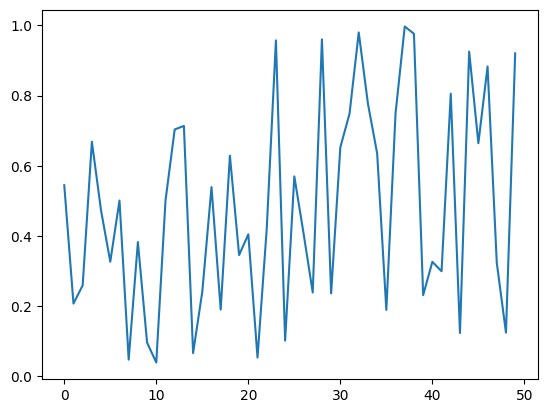

In [4]:
from random import random
import matplotlib as mpl, matplotlib.pyplot as plt
plt.plot([random() for _ in range(50)]);

`random()` should return uniformly distributed random numbers.
If we call it lots of times and plot its histogram, we should see a fairly  evenly spread.

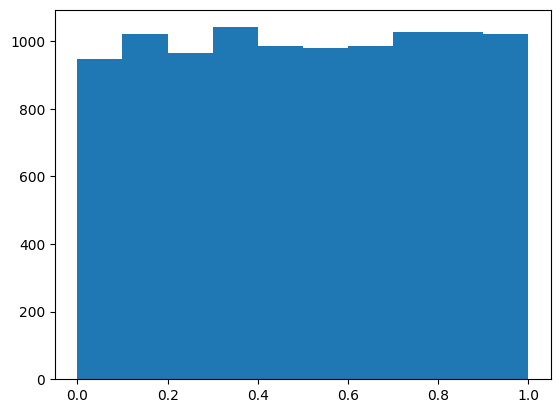

In [5]:
plt.hist([random() for _ in range(10000)]);

### Hardware Random Number Generator

There is no way in pure software to create a random number. 
We need a [Hardware random number generator](https://en.wikipedia.org/wiki/Hardware_random_number_generator).
There are some services that provide such:
- The [Australian National University quantum random number generator](https://qrng.anu.edu.au) looks at the quantum fluctuations of a vacuum and provides an API which will return them.
- Cloudflare has a wall of [lava lamps](https://www.cloudflare.com/learning/ssl/lava-lamp-encryption/) and uses the pixels of a camera looking at them to generate random numbers. 
- See also [drand](https://pypi.org/project/drand/), a network for "publicly verifiable, unbiased, and unpredictable random values".

### Intel/AMD chip version
[rdrand](https://pypi.org/project/rdrand/) is a Python module that provides an interface to the random number generator provided by Intel (and some Amd) processors.

In [6]:
import platform

# Get the machine type (e.g., 'x86_64', 'AMD64', 'arm64')
machine_type = platform.machine()
print(f"Machine Type: {machine_type}")

# Get the processor name (more detailed information, OS-dependent)
processor_name = platform.processor()
print(f"Processor Name: {processor_name}")

# Get a tuple containing various system information
uname = platform.uname()
print(f"System Information: {uname}")
print(f"Processor from uname: {uname.processor}")

Machine Type: arm64
Processor Name: arm
System Information: uname_result(system='Darwin', node='Germans-Mac-mini.local', release='24.3.0', version='Darwin Kernel Version 24.3.0: Thu Jan  2 20:22:58 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8132', machine='arm64')
Processor from uname: arm


In [7]:
if machine_type == 'x86_64':
    import rdrand
    from rdrand import RdRandom, RdSeedom
    r = RdRandom()
    rs = RdSeedom()
    r.getrandbytes(10), r.randint(1,10000), rs.randint(1,10000)
else: print("Rdrand not supported")

Rdrand not supported


## [Secrets](https://docs.python.org/3/library/secrets.html)
The secrets module is used for generating cryptographically strong random numbers suitable for managing data such as passwords, account authentication, security tokens, and related secrets.
Secrets should be used in preference to the default pseudo-random number generator in the random module, which is designed for modelling and simulation, not security or cryptography.
The secrets module provides access to the most secure source of randomness that your operating system provides.

In [ ]:
import os
import secrets  # For generating secure random numbers

def get_hardware_seed_bytes(num_bytes=32):
    """Gets a sequence of random bytes from the OS's entropy source."""
    return os.urandom(num_bytes)

def get_hardware_seed_int():
    """Gets a large integer seed from the OS's entropy source."""
    random_bytes = get_hardware_seed_bytes(32)  # Adjust number of bytes as needed
    return int.from_bytes(random_bytes, byteorder='big')

def get_hardware_seed_hex():
    """Gets a hexadecimal representation of the random bytes."""
    return get_hardware_seed_bytes().hex()

In [24]:
def get_HW_seed(): return (secrets.randbits(256))

get_HW_seed()

114856776411439333079484706611848568122987318314193601482646974117536900437369

## Quantumrandom
The [quantumrandom](https://pypi.org/project/quantumrandom/) project
provides tools for interacting with [The ANU Quantum Random Number Generator](qrng.anu.edu.au):
It communicates with their JSON API and provides a qrandom command-line tool, a Python API, and a Linux /dev/qrandom character device. 
NB: In 2025 they require to sign-up to get either a free tier or paid tier.  Without it, it will probably provide a single value every t seconds...

In [8]:
%pip install -q quantumrandom

Note: you may need to restart the kernel to use updated packages.


In [9]:
import quantumrandom

In [10]:
q = quantumrandom.get_data(data_type='uint16', array_length=3)
s1 = q[0]*q[1]*q[2]
print("s1=", s1) 

s1= 23708324939914


These remote services can be  slow, and they may limit access or fail often, so use them to get random numbers from time to time. 
But we want a way of getting lots of random numbers, so we use a [PRNG](https://en.wikipedia.org/wiki/Pseudorandom_number_generator).

### Reimplementing Python pseudo-random Random
There is a random in the standard library, but it is instructive to build it from scratch.
Based on the [Wichmann Hill algorithm](https://en.wikipedia.org/wiki/Wichmann–Hill) that was used before Python 2.3.

We're going to create `rand()` a function that has the above properties. 
Random state `rnd_state` is a global variable of one or more numbers. 
We start with no random state at all, and define a function `seed()` that we're going to pass something to. 
To create this initial number we can (a) "mash the keyboard", (b) get it from a hardware generator, or (c) use the current tick count in nanoseconds.
In Python we often use the number 42.
There's various ways of getting some random starting point.
When we pass it into `seed()`, it's going to do a bunch of modular divisions, 
create a tuple of three things, and store them in this global state, `rnd_state`.

In [11]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [12]:
seed(s1)
rnd_state

(27923, 21625, 25846)

In [13]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

`rand()` returns (pseudo) random numbers. We pull out the random state at the start, do some math ops to it, 
and then store a new random state `rnd_state`.
Each time we call it we get a different number, so this is a random number generator.
<mark>  NB: random number generators rely on this `rnd_state` state.</mark>

In [14]:
rand(),rand(),rand()

(0.37463170665740186, 0.8888740220164056, 0.017174392163634256)

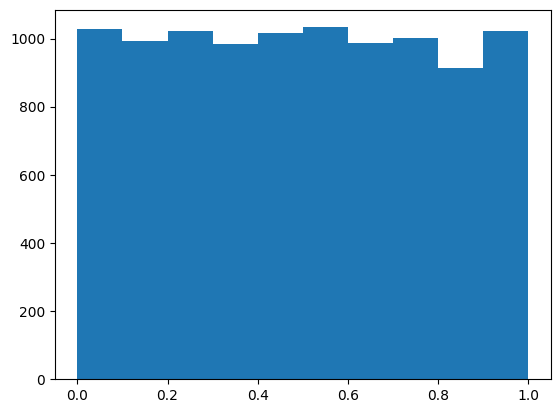

In [15]:
plt.hist([rand() for _ in range(10000)]);

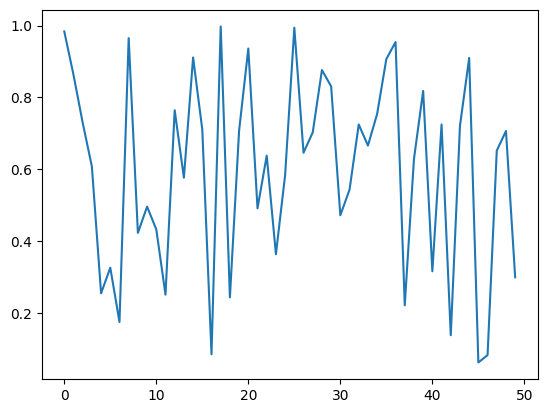

In [16]:
plt.plot([rand() for _ in range(50)]);

### Problem with initialization in Pytorch and Numpy

`os.fork()` creates a whole separate copy of a Python process. 
In one copy, the parent, `os.fork()` returns True, and on the other copy, the child, it returns `False`.
In each copy we call `rand()`, and expect to get 2 different random numbers. 
But (often) they are the same number, because the processes are copies, they both contain the same numbers in random state.  
In Deep Learning we often do parallel processing, for example, to generate lots of augmented images at the same time, using multiple processes.  
fastai used to have a bug where we failed to correctly initialize the random number generator separately, in each process.  

In [34]:
import warnings

# Ignore all warnings
#warnings.filterwarnings("ignore")

# Ignore specific warnings by category
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [25]:
import os

In [35]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.8503860090649389
In child: 0.8503860090649389


To fix the above we need to reinitialize the seed with the HW seed in each process.

In [36]:
if os.fork(): seed(get_HW_seed()), print(f'In parent: {rand()}')
else:
    seed(get_HW_seed())
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.20100466863541633
In child: 0.41406514405723316


In [40]:
import torch
tv11 = torch.__version__ ; tv11

'2.6.0'

Currently (2025), `torch.rand()` fails to initialize the random number generator. 
Pytorch does not re-initialize the random stream on the different processes :(

In [41]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.2865])
In child: tensor([0.2865])


Numpy does NOT re-initialize the random stream 

In [43]:
import numpy as np
if os.fork(): print(f'In parent: {np.random.rand(1)}')
else:
    print(f'In child: {np.random.rand(1)}')
    os._exit(os.EX_OK)

In parent: [0.61365451]
In child: [0.61365451]


Python correctly re-initializes the random stream!

In [44]:
from random import random
if os.fork(): print(f'In parent: {random()}')
else:
    print(f'In child: {random()}')
    os._exit(os.EX_OK)

In parent: 0.9857226949070897
In child: 0.17377572938380292


We can use Pytorch's function [`torch.matmul()`](https://pytorch.org/docs/stable/generated/torch.matmul.html) or its shorthand operator `@` directly for matrix multiplication.

In [ ]:
test_close(tr, x_train@weights, eps=1e-3)

In [ ]:
%timeit -n 1 _=torch.matmul(x_train, weights)

## APPLE Secrets

In [1]:
import secrets

print(secrets.token_bytes(16))  # 16 random bytes


b'd\xd49\xc4\xbdKUW\xad\xc2\x8d\x81\x9d8(\xd9'


In [3]:
secrets.token_hex(16)

'98aab36f7c38db15f21756cb4008b80f'

In [5]:
import os
if os.fork(): print(f'In parent: {secrets.token_hex(16)}')
else:
    print(f'In child: {secrets.token_hex(16)}')
    os._exit(os.EX_OK)

In parent: 9c29b8c0c7c7413a7a3a8cbd9995f938
In child: 24e87f96b87ac434128a0c943edf4fb4

/var/folders/77/07n57zdj7fxdw7hbt67q0b640000gn/T/ipykernel_5239/1964791525.py:2: DeprecationWarning: This process (pid=5239) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {secrets.token_hex(16)}')
